In [60]:
from joblib import dump, load 
import sys
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn, re
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA

In [135]:
def load_aggregate_matrices(direc):
    if os.path.exists(direc):
        spk_vecs = load(os.path.join(direc,'spk_vecs'))
        ph_vecs = load(os.path.join(direc,'ph_vecs'))
        spk_ph_vecs = load(os.path.join(direc,'spk_ph_vecs'))
    return spk_vecs, ph_vecs, spk_ph_vecs


def remaining_variance_ratio(vecs, pca):
    '''
    compute the amount of variance remaining in vecs
    after collapsing each of the principal components of pca
    '''
    vecs_n = vecs - np.mean(vecs, axis=0)
    variance_left = []
    pca_vecs = PCA(n_components=len(vecs))
    pca_vecs.fit(vecs)
    variance_left.append(sum(pca_vecs.explained_variance_))
    for pc in pca.components_:
        proj = np.dot(np.array(vecs_n), pc)
        collapsed_vecs = np.array(vecs_n) - np.dot(proj[:,None],pc[None,])
        pca_collapsed = PCA(n_components=len(vecs))
        pca_collapsed.fit(collapsed_vecs)
        variance_left.append(sum(pca_collapsed.explained_variance_))
        vecs_n = collapsed_vecs
    pca_variance = np.concatenate([np.array([0,]),np.cumsum(pca.explained_variance_ratio_)])
    return np.array(variance_left)/variance_left[0], pca_variance

def compute_pca(direc):
    spk_vecs, ph_vecs, spk_ph_vecs = load_aggregate_matrices(direc)
    spk_pca = PCA(n_components=40)
    spk_pca.fit(spk_vecs)
    ph_pca = PCA(n_components=39)
    ph_pca.fit(ph_vecs)
    joint_pca = PCA(n_components=100)
    joint_pca.fit(spk_ph_vecs)
    return spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs

def phone_versus_speaker(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return remaining_variance_ratio(ph_vecs, spk_pca)

### Sanity check: the remaining variance ratio and the explained_variance_ratio provided by sklearn should sum to 1

In [122]:
direc = 'aggregated_vectors/cpc_big/layer2'
spk_pca, ph_pca, joint_pca, _, _, _ = compute_pca(direc)

In [123]:
ph_var, _ = remaining_variance_ratio(ph_vecs, phone_pca)

In [124]:
ph_var[1:] + np.cumsum(phone_pca.explained_variance_ratio_)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

### Comparing similarity plot against the corresponding "remaining variance" plot

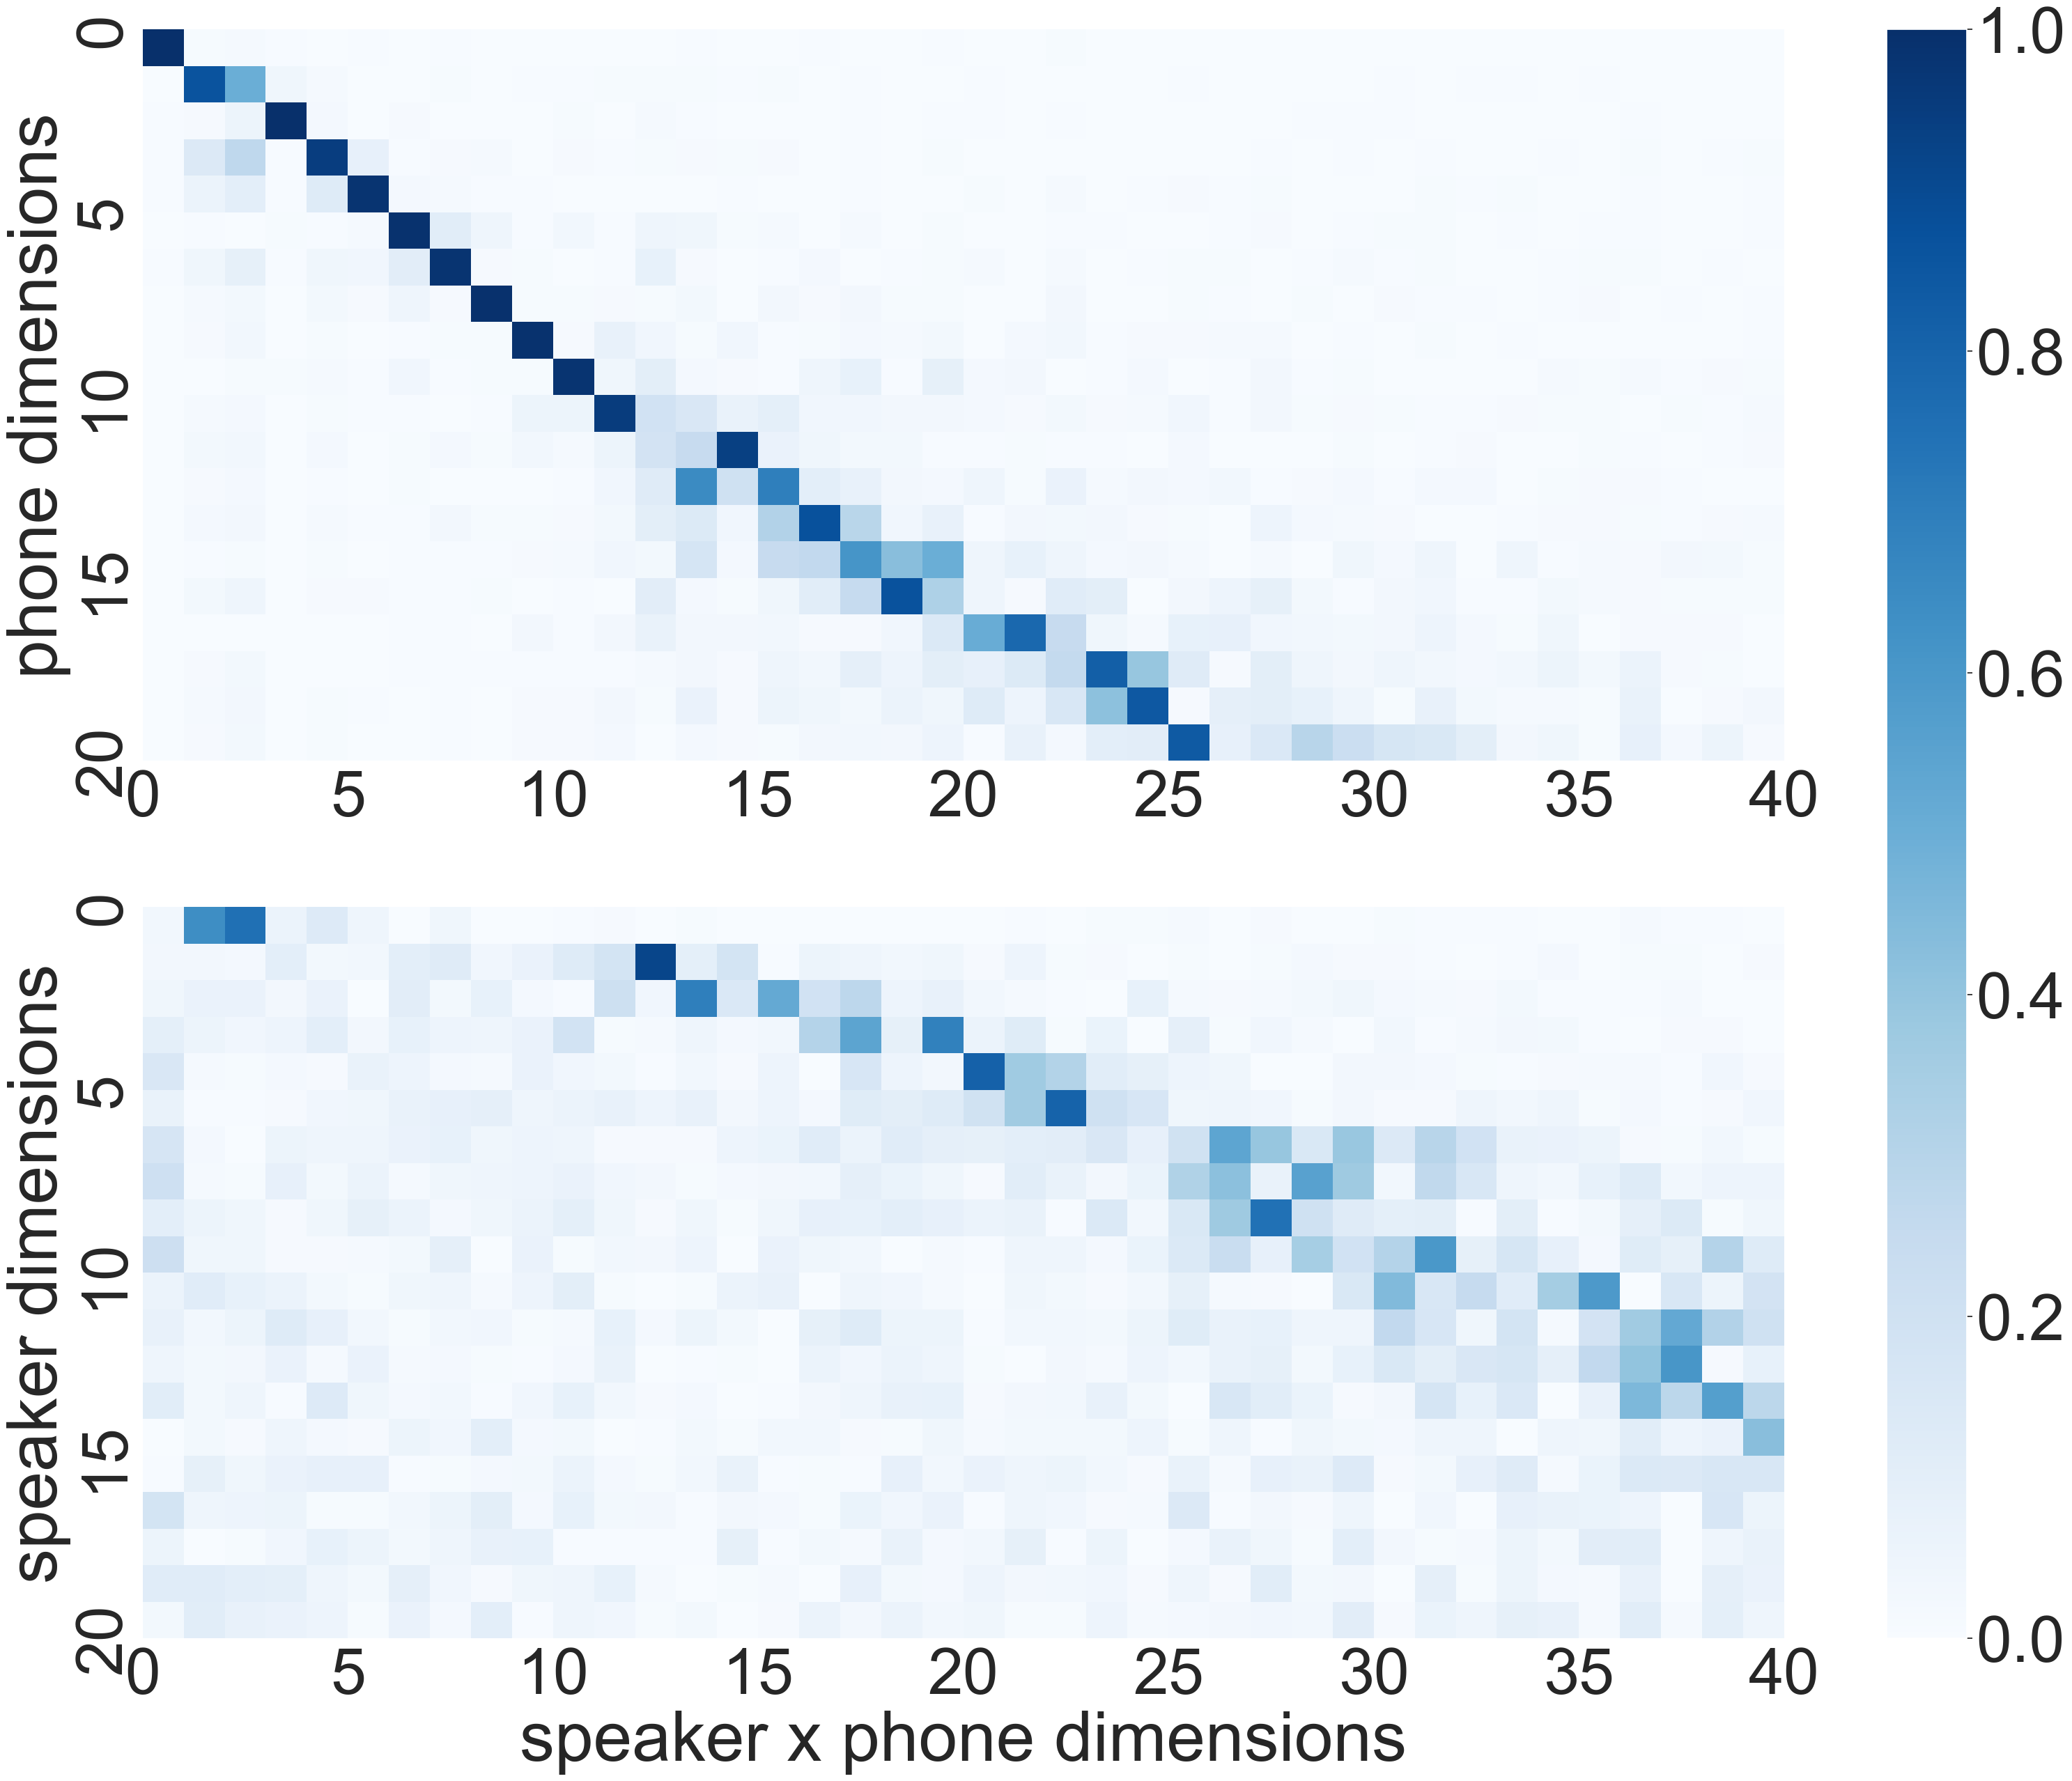

In [125]:
sm = plt.cm.ScalarMappable(cmap="Blues")
# plt.figure(figsize=(35,15))
# plt.autoscale()
sns.set(font_scale=6) 
f, axes = plt.subplots(2,1, figsize=(38,30))
s=sns.heatmap(np.abs(np.dot(ph_pca.components_[:20], joint_pca.components_[:40].transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[0])
s.set_ylabel('phone dimensions')
yticks = [0,5,10,15,20]
xticks = np.linspace(0,40,9).astype(int)
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)

s=sns.heatmap(np.abs(np.dot(spk_pca.components_[:20], joint_pca.components_[:40].transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[1])
s.set_ylabel('speaker dimensions')
s.set_xlabel('speaker x phone dimensions')
yticks = [0,5,10,15,20]
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)
f.colorbar(sm, ax=axes.flatten(),orientation="vertical")
# plt.tight_layout()
# plt.savefig('spk_ph_dimensions_cpc_small.pdf',dpi=300, bbox_inches='tight')
sns.set(font_scale=1) 

In [126]:
ph_var, spk_var = phone_versus_speaker(direc)

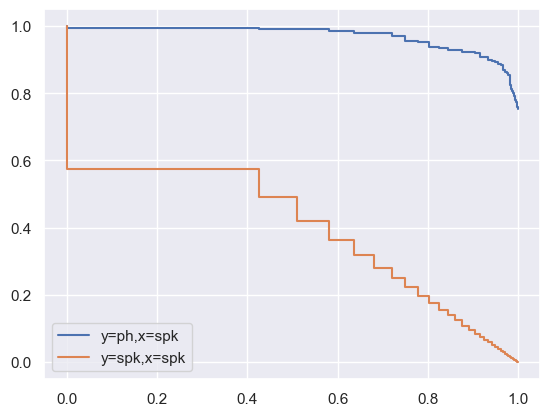

In [127]:
plt.step(spk_var,ph_var,label='y=ph,x=spk')
plt.step(spk_var,1-spk_var,label='y=spk,x=spk')
plt.legend()

the speaker versus speaker curve gives us the baseline

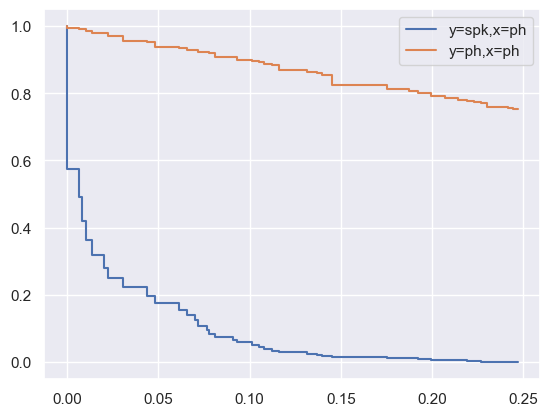

In [128]:
plt.step(1-ph_var,1-spk_var,label='y=spk,x=ph')
plt.step(1-ph_var,ph_var,label='y=ph,x=ph')
plt.legend()


## Now we can start comparing between layers of CPC big, as well as initialised versus after training

In [136]:
ph_var_cnn, spk_var_cnn = phone_versus_speaker('aggregated_vectors/cpc_big/cnn')
ph_var_l1, spk_var_l1 = phone_versus_speaker('aggregated_vectors/cpc_big/layer1')
ph_var_l2, spk_var_l2 = phone_versus_speaker('aggregated_vectors/cpc_big/layer2')
ph_var_l3, spk_var_l3 = phone_versus_speaker('aggregated_vectors/cpc_big/layer3')
ph_var_l4, spk_var_l4 = phone_versus_speaker('aggregated_vectors/cpc_big/layer4')
ph_var_l2i, spk_var_l2i = phone_versus_speaker('aggregated_vectors/cpc_big/layer2_init')

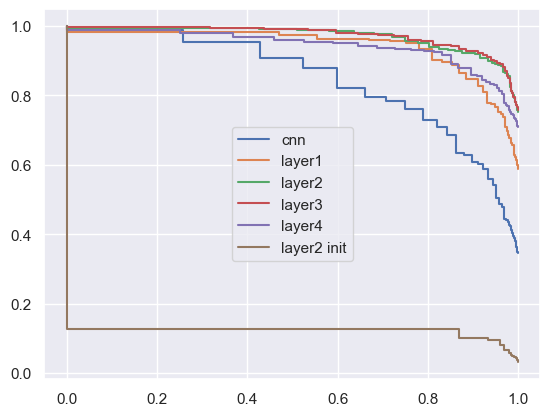

In [137]:
plt.step(spk_var_cnn,ph_var_cnn,label='cnn')
# plt.step(spk_var,1-spk_var,label='cnn_baseline')
plt.step(spk_var_l1,ph_var_l1,label='layer1')
plt.step(spk_var_l2,ph_var_l2,label='layer2')
plt.step(spk_var_l3,ph_var_l3,label='layer3')
plt.step(spk_var_l4,ph_var_l4,label='layer4')
plt.step(spk_var_l2i,ph_var_l2i,label='layer2 init')
plt.legend()

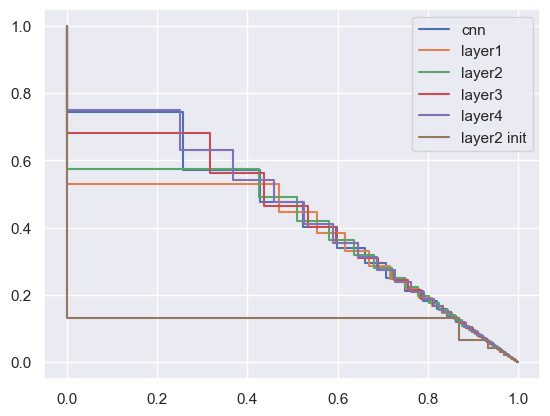

In [138]:
# Baselines
plt.step(spk_var_cnn,1-spk_var_cnn,label='cnn')
plt.step(spk_var_l1,1-spk_var_l1,label='layer1')
plt.step(spk_var_l2,1-spk_var_l2,label='layer2')
plt.step(spk_var_l3,1-spk_var_l3,label='layer3')
plt.step(spk_var_l4,1-spk_var_l4,label='layer4')
plt.step(spk_var_l2i,1-spk_var_l2i,label='layer2 init')
plt.legend()

## Comparing between different models

In [139]:
ph_var_cb, spk_var_cb = phone_versus_speaker('aggregated_vectors/cpc_big/layer2')
ph_var_cs, spk_var_cs = phone_versus_speaker('aggregated_vectors/cpc_small/layer2')
ph_var_apc, spk_var_apc = phone_versus_speaker('aggregated_vectors/apc/epoch19')
# spk_pca, ph_pca, joint_pca = compute_pca('aggregated_vectors/apc/epoch19')
# ph_var_apc, spk_var_apc = remaining_variance_ratio(ph_vecs, spk_pca)

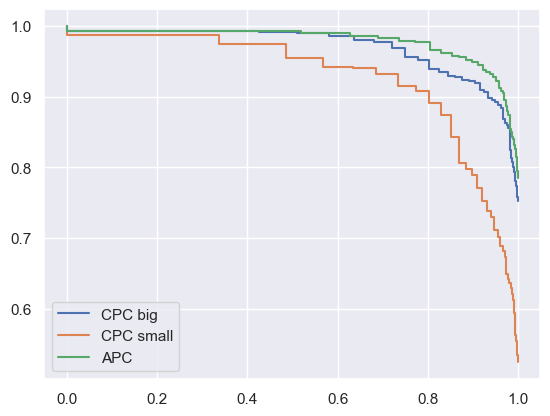

In [142]:
plt.step(spk_var_cb,ph_var_cb,label='CPC big')
plt.step(spk_var_cs,ph_var_cs,label='CPC small')
plt.step(spk_var_apc,ph_var_apc,label='APC')
plt.legend()

## Comparing between epochs of APC

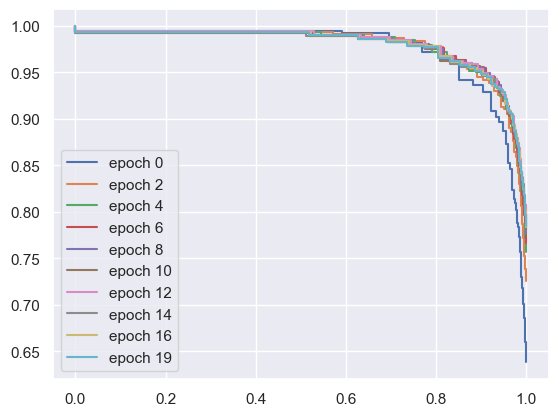

In [146]:
epochs=[0,2,4,6,8,10,12,14,16,19]
ph_var_epochs = []
spk_var_epochs = []
for e in epochs:
    ph_var, spk_var = phone_versus_speaker('aggregated_vectors/apc/epoch%s'%str(e))
    ph_var_epochs.append(ph_var)
    spk_var_epochs.append(spk_var)
    plt.step(spk_var,ph_var,label='epoch %s'%str(e))
plt.legend()

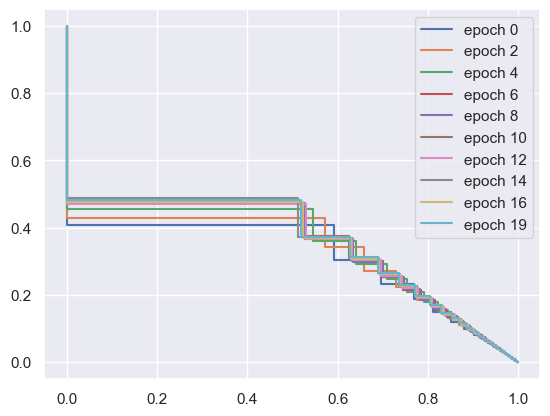

In [148]:
for i, e in enumerate(epochs):
    plt.step(spk_var_epochs[i],1-spk_var_epochs[i],label='epoch %s'%str(e))
plt.legend()

## If we look at the endpoints only

In [149]:
for i, e in enumerate(epochs):
    print(ph_var_epochs[i][-1])

0.63852082728817
0.725307959481913
0.7569246733788476
0.7666936037820872
0.7759822163362613
0.7813892770073602
0.7867635214976922
0.7840676903845267
0.7836549310581339
0.7850620644055132
